In [1]:
import librosa
import threading
import numpy as np
from numpy.random import randint
from os import listdir, walk
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import keras
from keras.models import Input, Model
from keras.layers import LSTM, Dense, Merge, Reshape

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
NORMAL_CORPUS = './vocalizationcorpus_normal/'
NUM = 242550
LAUGH = '../data/laugh/'
NOISY_CORPUS = './vocalizationcorpus_noisy/data/'
SRATE = 22050

In [3]:
def get_labels(path=NORMAL_CORPUS):
    files = []
    labels = {}
    with open(path + "labels.txt") as f:
        for sample in f.readlines():
            columns = sample.split(',')
            fname = columns[0]
            if fname != '':
                if fname not in labels:
                    labels[fname] = []
                files.append(fname)
                for i in range(4, len(columns), 3):
                    if columns[i] == 'laughter':
                        labels[fname].append((float(columns[i + 1]), float(columns[i + 2])))
                
    return files, labels

In [4]:
filelist, filelabels = get_labels()

In [5]:
def get_wav(fnames, path=NORMAL_CORPUS):
    data = np.zeros((len(fnames), NUM))
    invert_index = {}
    for i, f in enumerate(fnames):
        audio = librosa.load(path + 'data/' + f + '.wav', sr=SRATE)[0]
        data[i, :audio.shape[0]] = audio
        invert_index[f] = i
    return data, invert_index

In [6]:
wav_fnames, laugh_index = get_wav(filelist)

In [7]:
wav_fnames.shape

(2763, 242550)

In [8]:
wav_fnames

array([[-1.23602338e-03, -4.77461901e-04,  2.16727704e-03, ...,
        -2.64252676e-03, -3.55974361e-02,  2.01704074e-02],
       [ 1.80671718e-02,  2.69786939e-02,  2.94923503e-02, ...,
         3.16497433e-04, -4.29767795e-04,  4.08909487e-04],
       [-5.57697238e-03, -5.33851609e-03,  4.28238930e-03, ...,
        -1.69942796e-01, -4.41842675e-01, -7.40929723e-01],
       ...,
       [-1.62141562e-01, -3.08892369e-01, -4.34565574e-01, ...,
         5.22426255e-02,  1.54459059e-01,  2.75392801e-01],
       [ 3.01860797e-04,  3.04410374e-03,  1.20574085e-03, ...,
        -6.75202394e-03, -1.41960857e-02,  1.63377845e-03],
       [ 9.75174904e-01,  1.07687783e+00,  9.19921458e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
laugh_index.items()

In [10]:
def yield_samples(fnames, laugh_audio, laugh_index,  labels, path=LAUGH):
    while True:
        track_name = fnames[randint(0, len(fnames))]
        audio = laugh_audio[laugh_index[track_name]]
        label = []
        if track_name in labels:
            label = labels[track_name]
        yield (audio, label)

In [11]:
generator = yield_samples(filelist,wav_fnames,laugh_index,filelabels)

In [12]:
def get_noise_files(folder):
    noises = []
    for idx, noise_file in enumerate(listdir(folder)):
#         print("# {0} file {1}".format(idx,folder + noise_file))
        noise = librosa.load(folder + noise_file, sr=SRATE)[0]
        noises.append(noise)
    return noises

In [13]:
noises = get_noise_files(NOISY_CORPUS)

In [15]:
noises

[array([-0.02494384, -0.02760394, -0.02233786, ...,  0.0058138 ,
         0.01881178,  0.02636458], dtype=float32),
 array([ 0.00468313,  0.00103556, -0.00227582, ...,  0.00087148,
        -0.00247422, -0.00346763], dtype=float32),
 array([-0.00233702, -0.00254808, -0.00342595, ...,  0.00164526,
         0.00357056,  0.00572081], dtype=float32),
 array([-0.0103496 , -0.01313815, -0.00779239, ..., -0.0018633 ,
        -0.0063902 , -0.00758141], dtype=float32),
 array([ 0.0025315 , -0.00063614, -0.00114177, ..., -0.14491124,
        -0.4518039 , -0.60507005], dtype=float32),
 array([-0.00324293, -0.00567607, -0.00173693, ..., -0.00216969,
        -0.00452457,  0.00259336], dtype=float32),
 array([ 0.00564529,  0.0018439 , -0.00563464, ...,  0.00049779,
         0.00404891, -0.00314216], dtype=float32),
 array([-0.15421313, -0.12965286, -0.04343127, ..., -0.02701107,
        -0.06810643, -0.09686947], dtype=float32),
 array([-0.0036591 , -0.00479082,  0.00130438, ..., -0.00348869,
       

In [16]:
def yield_samples_with_noise():
    while True:
        yield noises[randint(0, len(noises))]        

In [17]:
generator_noise = yield_samples_with_noise()

In [36]:
def features(wav, SIZE_M = 96, SIZE_FFT = 2048):
    val = librosa.feature.melspectrogram(y=wav, sr=SRATE, n_fft=SIZE_FFT, n_mels=SIZE_M)
    val = librosa.power_to_db(val, np.max)
    return val, librosa.feature.mfcc(S=val)

In [37]:
def add_noise_to_sample(sample, noise):
    noise, _ = librosa.effects.trim(noise)

    size_noise = noise.shape[0]
    size_sample = sample.shape[0]
    
    if size_noise > size_sample:
        idx = randint(0, size_noise - size_sample)
        noise = noise[idx: idx + size_sample]
    
    if size_noise < size_sample:
        idx = (size_sample + size_noise - 1) // size_noise
        noise = np.tile(noise, idx)[:size_sample]

    return sample + noise
    

In [20]:
BATCH_SIZE = 16

In [60]:
def generate_data():
    while True:
        xs_f = np.zeros((BATCH_SIZE, 96, 474))
        xs_m = np.zeros((BATCH_SIZE, 20, 474))
        ys = np.zeros((BATCH_SIZE, 474))
        for i in range(BATCH_SIZE):
            track, label = next(generator)
            fbank, mfcc = features(add_noise_to_sample(track, next(generator_noise)))

            xs_f[i,:,:fbank.shape[1]] = fbank
            xs_m[i,:,:mfcc.shape[1]] = mfcc

            ys[i] = np.zeros((474,))
            for start, end in label:
                ys[i][int(start / 11. * 474.) :int(end / 11. * 474.)] = 1.

        xs_f = np.swapaxes(xs_f, 1, 2)
        xs_m = np.swapaxes(xs_m, 1, 2)
        yield [xs_f, xs_m], [ys, ys]

def get_sample():
    track, label = next(generator)
    fbank, mfcc = features(add_noise_to_sample(track, next(generator_noise)))
    x_f = np.array([np.swapaxes(fbank, 0, 1)])
    x_m = np.array([np.swapaxes(mfcc, 0, 1)])

    y = np.zeros((474,))
    for start, end in label:
        y[int(start / 11. * 474.) :int(end / 11. * 474.)] = 1.
    return [x_f, x_m], y

In [21]:
def model():
    fbank = Input(shape=(474, 96), dtype='float32', name='fbank')
    mfcc = Input(shape=(474, 20), dtype='float32', name='mfcc')
    
    lstm_mfcc = LSTM(units=128, return_sequences=True)(mfcc)
    mfcc_out = Dense(units=1, activation='sigmoid', name='mfcc_out')(lstm_mfcc)
    mfcc_out = Reshape((474,))(mfcc_out)
    
    lstm_fbank = LSTM(units=128, return_sequences=True)(fbank)
    
    merged_features = keras.layers.concatenate(inputs=[lstm_mfcc, lstm_fbank], axis=2)
    output = Dense(units=1, activation='sigmoid', name='output')(merged_features)
    output = Reshape((474,))(output)
    
    model = Model(inputs=[fbank, mfcc], outputs=[mfcc_out, output])
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    return model

In [22]:
model = model()

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

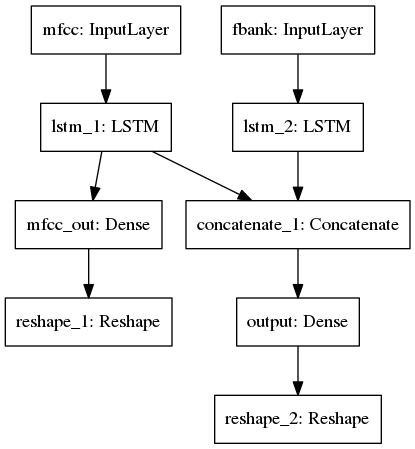

In [24]:
from IPython.display import Image
Image(filename='model.png') 

In [39]:
model.fit_generator(generate_data(), steps_per_epoch=10, epochs=100)

Epoch 1/100
10/10 [==============================] - 8s 839ms/step - loss: 0.3564 - reshape_1_loss: 0.1733 - reshape_2_loss: 0.1831 - reshape_1_acc: 0.9593 - reshape_2_acc: 0.9593
Epoch 2/100
10/10 [==============================] - 7s 748ms/step - loss: 0.3347 - reshape_1_loss: 0.1667 - reshape_2_loss: 0.1680 - reshape_1_acc: 0.9598 - reshape_2_acc: 0.9598
Epoch 3/100
10/10 [==============================] - 9s 856ms/step - loss: 0.3729 - reshape_1_loss: 0.1864 - reshape_2_loss: 0.1866 - reshape_1_acc: 0.9525 - reshape_2_acc: 0.9525
Epoch 4/100
10/10 [==============================] - 8s 837ms/step - loss: 0.3263 - reshape_1_loss: 0.1632 - reshape_2_loss: 0.1631 - reshape_1_acc: 0.9606 - reshape_2_acc: 0.9606
Epoch 5/100
10/10 [==============================] - 8s 786ms/step - loss: 0.2168 - reshape_1_loss: 0.1099 - reshape_2_loss: 0.1069 - reshape_1_acc: 0.9786 - reshape_2_acc: 0.9786
Epoch 6/100
10/10 [==============================] - 8s 811ms/step - loss: 0.2871 - reshape_1_loss: 

10/10 [==============================] - 8s 826ms/step - loss: 0.2716 - reshape_1_loss: 0.1362 - reshape_2_loss: 0.1354 - reshape_1_acc: 0.9670 - reshape_2_acc: 0.9670
Epoch 47/100
10/10 [==============================] - 8s 824ms/step - loss: 0.3043 - reshape_1_loss: 0.1524 - reshape_2_loss: 0.1520 - reshape_1_acc: 0.9619 - reshape_2_acc: 0.9619
Epoch 48/100
10/10 [==============================] - 8s 793ms/step - loss: 0.2605 - reshape_1_loss: 0.1308 - reshape_2_loss: 0.1297 - reshape_1_acc: 0.9689 - reshape_2_acc: 0.9689
Epoch 49/100
10/10 [==============================] - 8s 806ms/step - loss: 0.3115 - reshape_1_loss: 0.1561 - reshape_2_loss: 0.1553 - reshape_1_acc: 0.9611 - reshape_2_acc: 0.9611
Epoch 50/100
10/10 [==============================] - 8s 755ms/step - loss: 0.3009 - reshape_1_loss: 0.1513 - reshape_2_loss: 0.1497 - reshape_1_acc: 0.9621 - reshape_2_acc: 0.9621
Epoch 51/100
10/10 [==============================] - 7s 726ms/step - loss: 0.2732 - reshape_1_loss: 0.1369 

10/10 [==============================] - 9s 876ms/step - loss: 0.3517 - reshape_1_loss: 0.1763 - reshape_2_loss: 0.1753 - reshape_1_acc: 0.9546 - reshape_2_acc: 0.9546
Epoch 92/100
10/10 [==============================] - 8s 791ms/step - loss: 0.2807 - reshape_1_loss: 0.1410 - reshape_2_loss: 0.1397 - reshape_1_acc: 0.9653 - reshape_2_acc: 0.9653
Epoch 93/100
10/10 [==============================] - 8s 828ms/step - loss: 0.2873 - reshape_1_loss: 0.1445 - reshape_2_loss: 0.1429 - reshape_1_acc: 0.9637 - reshape_2_acc: 0.9637
Epoch 94/100
10/10 [==============================] - 8s 791ms/step - loss: 0.2283 - reshape_1_loss: 0.1147 - reshape_2_loss: 0.1136 - reshape_1_acc: 0.9738 - reshape_2_acc: 0.9738
Epoch 95/100
10/10 [==============================] - 9s 895ms/step - loss: 0.2287 - reshape_1_loss: 0.1153 - reshape_2_loss: 0.1134 - reshape_1_acc: 0.9729 - reshape_2_acc: 0.9729
Epoch 96/100
10/10 [==============================] - 8s 850ms/step - loss: 0.2839 - reshape_1_loss: 0.1426 

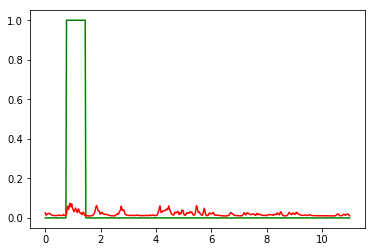

In [74]:
x, y = get_sample()
result = model.predict(x)
x_axis = np.linspace(0, 11, 474)
plt.plot(x_axis, y, 'g')
plt.plot(x_axis, result[1][0], 'r')
plt.show()

In [83]:
data_batch = generate_data()

In [93]:
def eval():
    x, y = next(data_batch)
    y = y[:len(y) // 2]
    result = model.predict(x)

    ys = np.reshape(y, (BATCH_SIZE * 474,))
    result_0 = np.reshape(result[0], (BATCH_SIZE * 474,))
    result_1 = np.reshape(result[1], (BATCH_SIZE * 474,))
    
    print('MFCC roc_auc_score ', roc_auc_score(ys, result_1))
    print('roc_auc_score on', roc_auc_score(ys, result_0))

In [97]:
eval()

('MFCC roc_auc_score ', 0.8196468580841927)
('roc_auc_score on', 0.7964694305322406)
